In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
tsla = yf.Ticker("TSLA")

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [20]:
hist = tsla.history(period="1y",interval="1h")

In [22]:
hist.Open

Date
2020-02-10    152.459000
2020-02-10    150.839996
2020-02-10    152.907990
2020-02-10    155.522400
2020-02-10    156.662003
                 ...    
2021-02-09    844.609985
2021-02-10    843.000000
2021-02-10    817.919983
2021-02-10    813.630005
2021-02-10    811.607971
Name: Open, Length: 1766, dtype: float64

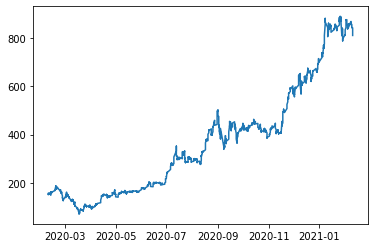

In [21]:
plt.plot(hist.Open)

The yfinance API lets us get different granularity (for TSLA anyways):
    - minutly: data for 7 days/request, and only in the last 30 days
    - bi-minutly to hourly (not included): data for 60 days, and only in the last 60 days
    - hourly: data for 730 days, and only in the last 730 days
    - daily: can get for max amount of time

In [39]:
import pickle
import datetime as dt
import numpy as np

In [24]:
data = pickle.load(open("data_h.pickle","rb"))

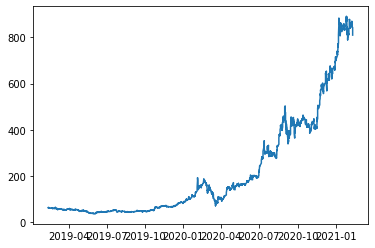

In [25]:
plt.plot(data.Open)

3518
2637


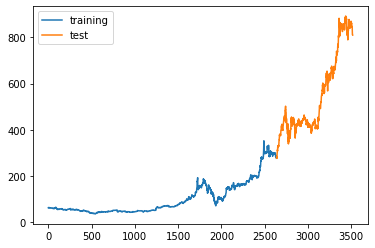

In [121]:
data = data.reset_index()
tsla_open = data.Open
series = tsla_open

### general operations
series_length = np.size(series)
print(series_length)
#3518 data points, 1/4th of which is about 880
split_idx = series_length//4*3
print(split_idx)
train = series.iloc[:split_idx]
test = series.iloc[split_idx:]
plt.plot(train)
plt.plot(test)
plt.legend(["training","test"])

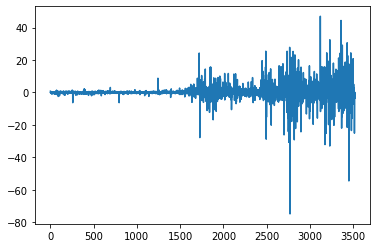

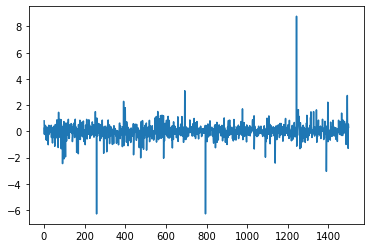

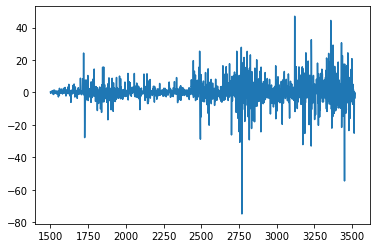

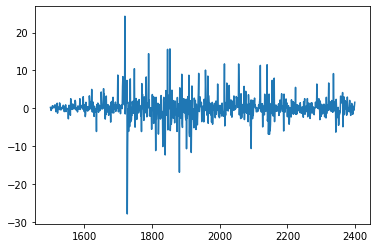

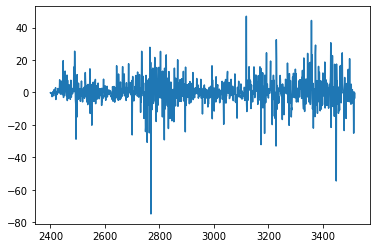

In [182]:
#testing differatinating operator
Dseries = series.diff() #"inverse" operation is cumsum()
plt.figure(0)
plt.plot(Dseries)
plt.figure(1)
plt.plot(Dseries[:1500])
plt.figure(2)
plt.plot(Dseries[1500:])
plt.figure(3)
plt.plot(Dseries[1500:2400])
plt.figure(4)
plt.plot(Dseries[2400:])

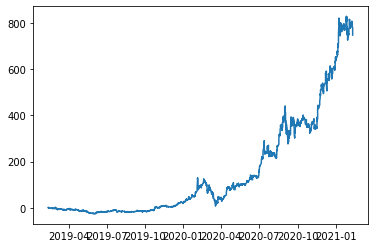

In [98]:
#reconstruction series from differentiated data (just testing the stuff out)
test = Dseries.cumsum()
plt.plot(test)

In [123]:
Dtrain = train.diff()

In [105]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [157]:
#Dtrain.index = pd.DatetimeIndex(Dtrain.index).to_period('H')
model = ARIMA(Dtrain, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 2637
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6032.071
Date:                Fri, 12 Feb 2021   AIC                          12070.141
Time:                        22:20:03   BIC                          12087.773
Sample:                             0   HQIC                         12076.525
                               - 2637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0813      0.048      1.691      0.091      -0.013       0.175
ar.L1          0.0173      0.008      2.288      0.022       0.002       0.032
sigma2         5.6906      0.036    156.666      0.000       5.619       5.762
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            143194.11
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              40.64   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
blop = data_length-split_idx
print(blop)
#newstuff = model_fit.forecast(steps=20)[0]
newstuff = model_fit.predict(start=len(Dtrain),end=len(Dtrain)+200)
newstuff.head()

881


2637   -0.568909
2638    0.147090
2639    0.209948
2640   -0.134983
2641    0.228836
Name: predicted_mean, dtype: float64

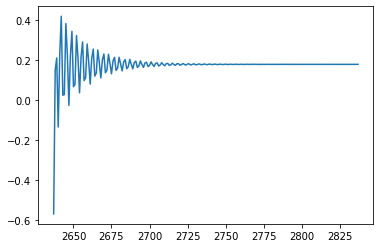

In [156]:
plt.plot(newstuff)

In [127]:
trended = newstuff.cumsum() + training_data.Open[-1]

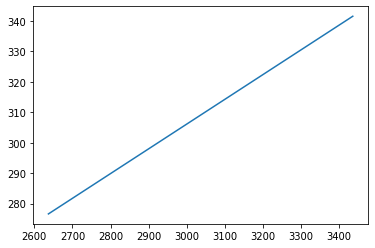

In [128]:
plt.plot(trended)

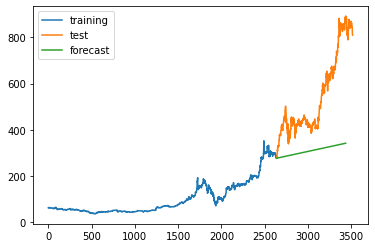

In [133]:
plt.plot(train)
plt.plot(test)
plt.plot(trended)
plt.legend(["training","test","forecast"])

In [117]:
series = series.reset_index()

In [120]:
series.head()
type(series)

pandas.core.frame.DataFrame

In [164]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [166]:
#lm = LinearRegression()
#print(train.shape)
#print(train.index.shape)
#lm.fit(train.reshape((-1,1)),train.index)

Y = train
X = train.index
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Open   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     5714.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:39:30   Log-Likelihood:                -13496.
No. Observations:                2637   AIC:                         2.700e+04
Df Residuals:                    2635   BIC:                         2.701e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8790      1.574     -1.194      0.2

In [172]:
x1 = 0.0782
cst = -1.8790
res = test.index*x1 + cst
res.index = test.index
reg_line = series.index*x1 + cst

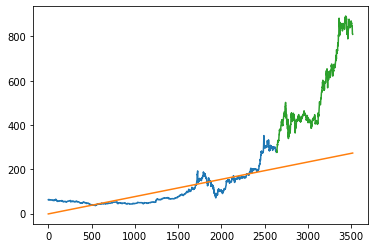

In [173]:
plt.plot(train)
plt.plot(reg_line)
plt.plot(test)

In [175]:
X

array([[1.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00],
       [1.000e+00, 2.000e+00],
       ...,
       [1.000e+00, 2.634e+03],
       [1.000e+00, 2.635e+03],
       [1.000e+00, 2.636e+03]])

In [1]:
import pandas as pd

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
test = pd.DataFrame([1,2,3,4,5])
print(test)

   0
0  1
1  2
2  3
3  4
4  5


In [4]:
print(test[2:3])

   0
2  3
